In [2]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch torchvision torchaudio

     ---------------------------------------- 3.7/3.7 MB 9.1 MB/s eta 0:00:00
     ------------------------------------- 663.9/663.9 kB 10.5 MB/s eta 0:00:00
     -------------------------------------- 111.0/111.0 MB 6.4 MB/s eta 0:00:00
     ---------------------------------------- 44.6/44.6 kB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 6.3/6.3 MB 11.5 MB/s eta 0:00:00
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: sympy
    Found existing installation: sympy 1.11.1
    Uninstalling sympy-1.11.1:
      Successfully uninstalled sympy-1.11.1
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 33.9 MB/s eta 0:00:00


In [1]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import global_add_pool
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem, rdchem
import matplotlib.pyplot as plt
import math

환경결정상수

In [2]:
# H5 파일 키 설정
KEY_CONFIG = {
    "atoms": "elements", "smiles": "Rsmiles",
    "R_coords": "RG", "TS_coords": "TSG", "P_coords": "PG",          
    "R_energy": { "H": "R_H", "G": "R_F", "E": "R_E" },
    "TS_energy": { "H": "TS_H", "G": "TS_F", "E": "TS_E" },
    "P_energy": { "H": "P_H", "G": "P_F", "E": "P_E" }
}

# 결합 해리 에너지 (BDE) 테이블 (kcal/mol)
BDE_TABLE = {
    (1, 1): 104, (1, 6): 99, (1, 7): 93, (1, 8): 111, (1, 9): 135,
    (6, 6): 83, (6, 7): 73, (6, 8): 86, (6, 9): 116,
    (7, 7): 39, (7, 8): 53, (8, 8): 35
}

# 원자 물성 [EN, Hardness, Radius, IE]
ATOM_PROPS_TABLE = {
    1: [2.20, 6.42, 0.31, 13.60], 6: [2.55, 5.00, 0.76, 11.26],
    7: [3.04, 7.27, 0.71, 14.53], 8: [3.44, 6.08, 0.66, 13.62], 9: [3.98, 7.01, 0.57, 17.42]
}
DEFAULT_PROPS = [0.0, 0.0, 0.0, 0.0]

# 작용기 SMARTS 패턴
FUNCTIONAL_GROUPS = {
    "Nitro": "[N+](=O)[O-]", "Sulfonyl": "S(=O)(=O)", "Cyano": "C#N", "Trifluoromethyl": "C(F)(F)F",
    "Carbonyl": "[CX3]=[OX1]", "Carboxyl": "[CX3](=O)[OX2H1]", "Halogen": "[F,Cl,Br,I]",
    "Amine": "[NX3;H2,H1,H0;!$(NC=O)]", "Hydroxy": "[OX2H]", "Alkoxy": "[OX2][CX4]", 
    "Amide": "[NX3][CX3](=O)", "Alkyl": "[CX4]", "Phenyl": "c1ccccc1"
}
FG_TYPE_MAP = {
    "Nitro": -1.0, "Sulfonyl": -1.0, "Cyano": -1.0, "Trifluoromethyl": -1.0,
    "Carbonyl": -0.5, "Carboxyl": -0.5, "Halogen": -0.2, "Amine": 1.0, "Hydroxy": 1.0, 
    "Alkoxy": 1.0, "Amide": 0.2, "Alkyl": 0.3, "Phenyl": 0.1
}

데이터셋

In [3]:
class ReactionDataset(Dataset):
    def __init__(self, h5_path, limit=None):
        super().__init__(None, transform=None, pre_transform=None)
        self.h5_path = h5_path
        if not os.path.exists(h5_path): raise FileNotFoundError(f"File not found: {h5_path}")
        with h5py.File(self.h5_path, 'r') as f:
            self.keys = list(f.keys())
            if limit: self.keys = self.keys[:limit]
            self.len_data = len(self.keys)
        self.fg_patterns = {name: Chem.MolFromSmarts(smarts) for name, smarts in FUNCTIONAL_GROUPS.items()}

    def len(self): return self.len_data

    def get_atom_features(self, mol):
        try: AllChem.ComputeGasteigerCharges(mol); 
        except:
            pass
        features, hsab_list = [], []
        
        # 작용기(Functional Group) 탐지
        atom_fg_info = {atom.GetIdx(): {'ewg':0.0, 'edg':0.0, 'types':[]} for atom in mol.GetAtoms()}
        for name, pattern in self.fg_patterns.items():
            if pattern:
                for match in mol.GetSubstructMatches(pattern):
                    effect = FG_TYPE_MAP.get(name, 0.0)
                    for idx in match:
                        if effect < 0: atom_fg_info[idx]['ewg'] += abs(effect)
                        elif effect > 0: atom_fg_info[idx]['edg'] += effect
                        atom_fg_info[idx]['types'].append(name)
        
        atoms_with_map = [(a.GetAtomMapNum() if a.GetAtomMapNum()!=0 else a.GetIdx()+1, a) for a in mol.GetAtoms()]
        atoms_with_map.sort(key=lambda x: x[0])
        
        for _, atom in atoms_with_map:
            feat = []
            z = atom.GetAtomicNum()
            idx = atom.GetIdx()
            
            # [1] Basic Info (21 dims)
            sym_map={'H':0,'C':1,'N':2,'O':3,'F':4}; oh=[0]*6; oh[sym_map.get(atom.GetSymbol(),5)]=1; feat.extend(oh)
            hyb=atom.GetHybridization(); hyb_map={rdchem.HybridizationType.SP:0, rdchem.HybridizationType.SP2:1, rdchem.HybridizationType.SP3:2, rdchem.HybridizationType.SP3D:3, rdchem.HybridizationType.SP3D2:4}; hyb_vec=[0]*5; 
            if hyb in hyb_map: hyb_vec[hyb_map[hyb]]=1
            feat.extend(hyb_vec)
            try: q=float(atom.GetProp('_GasteigerCharge')); 
            except: q=0.0
            if np.isnan(q): q=0.0
            feat.extend([q, float(atom.GetFormalCharge()), float(atom.GetTotalValence()), atom.GetMass()/20.0])
            feat.extend([1.0 if atom.IsInRingSize(s) else 0.0 for s in [3,4,5,6]])
            feat.extend([1.0 if atom.GetIsAromatic() else 0.0, 1.0 if atom.GetChiralTag()!=rdchem.ChiralType.CHI_UNSPECIFIED else 0.0])
            
            # [2] Functional Group Info (6 dims)
            info = atom_fg_info[idx]
            feat.extend([info['ewg'], info['edg'], 1.0 if 'Nitro' in info['types'] or 'Sulfonyl' in info['types'] else 0.0, 1.0 if 'Carbonyl' in info['types'] else 0.0, 1.0 if 'Amine' in info['types'] or 'Hydroxy' in info['types'] else 0.0, 1.0 if 'Halogen' in info['types'] else 0.0])
            features.append(feat)
            
            # [3] HSAB Props
            props = ATOM_PROPS_TABLE.get(z, DEFAULT_PROPS)
            hsab_list.append([-props[0], props[1]]) # [Chemical Potential, Hardness]
            
        return torch.tensor(features, dtype=torch.float), torch.tensor(hsab_list, dtype=torch.float)

    def get(self, idx):
        with h5py.File(self.h5_path, 'r') as f:
            group = f[self.keys[idx]]
            
            # RDKit Parsing
            if KEY_CONFIG["smiles"] in group:
                smi = group[KEY_CONFIG["smiles"]][()]; smi = smi.decode('utf-8') if isinstance(smi, bytes) else str(smi)
                mol = Chem.MolFromSmiles(smi)
                if mol: mol = Chem.AddHs(mol); x, hsab = self.get_atom_features(mol)
                else: atoms = group[KEY_CONFIG["atoms"]][()]; x = torch.zeros(len(atoms), 27); hsab = torch.zeros(len(atoms), 2)
            else: atoms = group[KEY_CONFIG["atoms"]][()]; x = torch.zeros(len(atoms), 27); hsab = torch.zeros(len(atoms), 2)
            
            # Coordinates
            pos_R = torch.tensor(group[KEY_CONFIG["R_coords"]][()], dtype=torch.float)
            pos_TS = torch.tensor(group[KEY_CONFIG["TS_coords"]][()], dtype=torch.float)
            pos_P = torch.tensor(group[KEY_CONFIG["P_coords"]][()], dtype=torch.float)
            
            # Energies
            e_R = torch.tensor([group[KEY_CONFIG["R_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_TS = torch.tensor([group[KEY_CONFIG["TS_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_P = torch.tensor([group[KEY_CONFIG["P_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            
            # Targets (Delta Learning ready: predicting barriers directly)
            y_fwd = (e_TS - e_R).unsqueeze(0)
            y_rev = (e_TS - e_P).unsqueeze(0)
            thermo = (e_P - e_R).unsqueeze(0)
            
            # Consistency Check
            if x.size(0)!=pos_R.size(0): m=min(x.size(0),pos_R.size(0)); x=x[:m]; hsab=hsab[:m]; pos_R=pos_R[:m]; pos_P=pos_P[:m]; pos_TS=pos_TS[:m]
            
            # Fully Connected Edges
            n=x.size(0); r=torch.arange(n).repeat_interleave(n); c=torch.arange(n).repeat(n); mask=r!=c
            edge_index=torch.stack([r[mask], c[mask]], dim=0)
            
            # BDE Features
            sym=torch.argmax(x[:,:6], dim=1); map_z={0:1,1:6,2:7,3:8,4:9,5:0}; z=torch.tensor([map_z.get(i.item(),0) for i in sym], dtype=torch.long)
            bde = [BDE_TABLE.get(tuple(sorted((int(z[i]), int(z[j])))), 80.0) for i,j in edge_index.T]
            edge_bde = torch.tensor(bde, dtype=torch.float).unsqueeze(-1)
            
            return Data(x=x, z=z, hsab=hsab, pos=pos_R, pos_P=pos_P, edge_index=edge_index, 
                        y_fwd=y_fwd, y_rev=y_rev, y_pos=pos_TS, thermo_energy=thermo, edge_bde=edge_bde)

GNN Backbone

In [4]:
class RBFLayer(nn.Module):
    """
    [Radial Basis Function Layer]
    거리 정보를 단순히 하나의 숫자가 아닌, 여러 개의 기저 함수(Gaussian)로 확장하여 표현합니다.
    이는 Geometric Deep Learning (SchNet, DimeNet)의 핵심 요소입니다.
    """
    def __init__(self, num_rbf=50, cutoff=5.0):
        super().__init__()
        self.cutoff = cutoff
        # 0 ~ cutoff 사이를 num_rbf 개수만큼 등분
        self.centers = nn.Parameter(torch.linspace(0, cutoff, num_rbf), requires_grad=False)
        self.widths = nn.Parameter(torch.tensor([cutoff / num_rbf] * num_rbf), requires_grad=False)

    def forward(self, dist):
        # Gaussian Smearing: exp(- (d - mu)^2 / beta)
        return torch.exp(-((dist - self.centers) ** 2) / self.widths)

In [5]:
class GeometricInteractionLayer(nn.Module):
    """
    [Geometric Interaction Block]
    RBF로 확장된 거리 정보를 이용하여 노드 간의 상호작용을 학습합니다.
    Simple MLP보다 훨씬 풍부한 기하학적 특징을 추출합니다.
    """
    def __init__(self, hidden_dim, num_rbf=50):
        super().__init__()
        self.rbf_lin = nn.Linear(num_rbf, hidden_dim)
        
        # Message Passing MLPs
        self.msg_net = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.update_net = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, h, edge_index, rbf_dist):
        row, col = edge_index
        
        # 1. 거리 정보 변환 (RBF -> Hidden)
        edge_geom = self.rbf_lin(rbf_dist) # [E, Hidden]
        
        # 2. 메시지 생성 (Source + Target) * Geometry
        # SchNet 방식의 Continuous Filter Convolution 아이디어 차용
        node_feat = torch.cat([h[row], h[col]], dim=-1)
        msg_raw = self.msg_net(node_feat)
        msg = msg_raw * edge_geom # Element-wise multiplication with Geometry
        
        # 3. 집계 (Aggregation)
        aggr = torch.zeros_like(h)
        aggr.index_add_(0, row, msg)
        
        # 4. 업데이트 (Update)
        update = self.update_net(torch.cat([h, aggr], dim=-1))
        
        return self.norm(h + update)

In [6]:
class GeometricGNN(nn.Module):
    """
    [Main Backbone]
    위상학적 정보뿐만 아니라 기하학적(RBF) 정보를 적극 활용하는 GNN입니다.
    """
    def __init__(self, node_dim, hidden_dim, num_layers=4):
        super().__init__()
        self.node_emb = nn.Linear(node_dim, hidden_dim)
        self.rbf = RBFLayer(num_rbf=50, cutoff=10.0)
        self.layers = nn.ModuleList([
            GeometricInteractionLayer(hidden_dim, num_rbf=50) for _ in range(num_layers)
        ])

    def forward(self, x, pos, edge_index):
        h = self.node_emb(x)
        
        # 거리 계산 및 RBF 변환
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        rbf_feat = self.rbf(dist) # [E, 50]
        
        for layer in self.layers:
            h = layer(h, edge_index, rbf_feat)
            
        return h

In [7]:
class SigmoidGating(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.gate_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 1, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 1), nn.Sigmoid()
        )
    def forward(self, h, edge_index, pos):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        return self.gate_mlp(torch.cat([h[row], h[col], dist], dim=-1))

In [8]:
class StructureDecoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(nn.Linear(hidden_dim*2, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, 1))
    def forward(self, h, edge_index, gate_score):
        row, col = edge_index
        return self.mlp(torch.cat([h[row], h[col]], dim=-1)) * gate_score

물리법칙

In [9]:
class PaulingBondLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.r0_table = torch.tensor([0.0, 0.31, 0.0, 0.0, 0.0, 0.0, 0.76, 0.71, 0.66, 0.57]) 
    def forward(self, z, edge_index, dist):
        row, col = edge_index
        r0_i = self.r0_table.to(z.device)[z[row]]
        r0_j = self.r0_table.to(z.device)[z[col]]
        r0_sum = (r0_i + r0_j).unsqueeze(-1)
        return torch.exp((r0_sum - dist) / 0.3)

In [10]:
class StereoelectronicLayer(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, pos_R, pos_P, edge_index):
        row, col = edge_index
        vec_R = F.normalize(pos_R[col] - pos_R[row], p=2, dim=-1)
        vec_P = F.normalize(pos_P[col] - pos_P[row], p=2, dim=-1)
        return (vec_R * vec_P).sum(dim=-1, keepdim=True)

In [11]:
class HSABInteractionLayer(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, hsab, edge_index):
        row, col = edge_index
        mu, eta = hsab[:, 0], hsab[:, 1]
        d_mu = (mu[row] - mu[col]).pow(2)
        sum_eta = eta[row] + eta[col]
        return (d_mu / (sum_eta + 1e-6)).unsqueeze(-1)

In [12]:
class StericLayer(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, pos, edge_index):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1)
        density = 1.0 / (dist.pow(2) + 0.1)
        steric = torch.zeros(pos.size(0), 1, device=pos.device)
        steric.index_add_(0, row, density.unsqueeze(-1))
        return steric

In [13]:
class HammondGate(nn.Module):
    def __init__(self):
        super().__init__()
        self.gate = nn.Sequential(nn.Linear(3, 16), nn.SiLU(), nn.Linear(16, 1), nn.Sigmoid())
    def forward(self, thermo): return self.gate(thermo)

Diffusion

In [14]:
class SinusoidalTimeEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [15]:
class DenoisingNetwork(nn.Module):
    """
    현재의 노이즈 섞인 좌표(pos_t)와 시간(t), 조건(R, P)을 받아
    추가된 노이즈(epsilon)를 예측하는 네트워크
    """
    def __init__(self, node_dim, hidden_dim, num_layers=3):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalTimeEmbeddings(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        
        # 기하학적 상호작용 레이어 재사용 (기존 코드의 클래스 활용)
        self.rbf = RBFLayer(num_rbf=50, cutoff=10.0)
        self.layers = nn.ModuleList([
            GeometricInteractionLayer(hidden_dim, num_rbf=50) for _ in range(num_layers)
        ])
        
        # 최종 노이즈 벡터(dx, dy, dz) 예측
        self.final_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 3) 
        )

    def forward(self, h, pos_t, t, edge_index):
        # 1. 시간 임베딩 처리
        time_emb = self.time_mlp(t) # [Batch, Hidden]
        
        # 노드별로 시간 정보 더해주기 (Broadcasting)
        # h: [Total_Nodes, Hidden], time_emb: [Batch, Hidden]
        # 배치를 고려하여 노드 특징에 시간 정보 주입
        batch_idx = torch.zeros(h.size(0), dtype=torch.long, device=h.device) # 임시 (실제론 data.batch 필요)
        # 여기서는 간단히 h에 time_emb를 더하는 식으로 구현 (Data 객체 내 batch 정보 활용 권장)
        
        # 2. 기하학적 특징 추출 (Noisy Position 기준)
        row, col = edge_index
        dist = (pos_t[row] - pos_t[col]).norm(dim=-1, keepdim=True)
        rbf_feat = self.rbf(dist)
        
        # GNN 통과
        h_curr = h
        for layer in self.layers:
            # Time Embedding을 레이어마다 주입하거나 초기에 더함
            h_curr = layer(h_curr, edge_index, rbf_feat)
            
        # 3. 노이즈 예측
        noise_pred = self.final_head(h_curr)
        return noise_pred

In [16]:
class TSDiffusionModule(nn.Module):
    def __init__(self, node_dim, hidden_dim, timesteps=100):
        super().__init__()
        self.timesteps = timesteps
        
        # Noise Schedule (Linear Beta Schedule)
        beta_start, beta_end = 1e-4, 0.02
        betas = torch.linspace(beta_start, beta_end, timesteps)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        
        # Register buffers (학습되지 않는 상수들)
        self.register_buffer('betas', betas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        
        self.denoise_net = DenoisingNetwork(node_dim, hidden_dim)

    # --- Training: Loss 계산 ---
    def compute_loss(self, true_ts_pos, h, edge_index, batch):
        batch_size = batch.max().item() + 1
        device = true_ts_pos.device
        
        # 1. 랜덤 타임스텝 샘플링
        t = torch.randint(0, self.timesteps, (batch_size,), device=device).long()
        
        # 2. 노이즈 생성
        noise = torch.randn_like(true_ts_pos)
        
        # 3. Noisy Image 생성 (Forward Process)
        # 노드별로 t를 매핑하기 위해 gather 사용
        t_node = t[batch] # [Total_Nodes]
        sqrt_alpha = self.sqrt_alphas_cumprod[t_node].unsqueeze(-1)
        sqrt_one_minus_alpha = self.sqrt_one_minus_alphas_cumprod[t_node].unsqueeze(-1)
        
        noisy_pos = sqrt_alpha * true_ts_pos + sqrt_one_minus_alpha * noise
        
        # 4. 노이즈 예측
        noise_pred = self.denoise_net(h, noisy_pos, t, edge_index)
        
        # 5. MSE Loss (예측 노이즈 vs 실제 노이즈)
        return F.mse_loss(noise_pred, noise)

    # --- Inference: 3D 구조 생성 ---
    @torch.no_grad()
    def sample(self, pos_R, pos_P, h, edge_index, batch):
        # 초기 추측: Reactant와 Product의 중점 (Interpolation)
        # OA-ReactDiff는 R/P를 조건으로 사용함. 여기선 Prior의 중심으로 사용.
        midpoint = (pos_R + pos_P) / 2.0
        
        # 초기 노이즈 ($x_T$)
        current_pos = midpoint + torch.randn_like(pos_R)
        
        # Reverse Process (T -> 0)
        for t in reversed(range(self.timesteps)):
            batch_size = batch.max().item() + 1
            t_batch = torch.full((batch_size,), t, device=pos_R.device, dtype=torch.long)
            
            # 노이즈 예측
            noise_pred = self.denoise_net(h, current_pos, t_batch, edge_index)
            
            # Update Position (DDPM update rule)
            alpha = 1 - self.betas[t]
            alpha_cumprod = self.alphas_cumprod[t]
            
            # 평균 계산
            pred_mean = (1 / torch.sqrt(alpha)) * (
                current_pos - (self.betas[t] / torch.sqrt(1 - alpha_cumprod)) * noise_pred
            )
            
            if t > 0:
                noise = torch.randn_like(current_pos)
                sigma = torch.sqrt(self.betas[t])
                current_pos = pred_mean + sigma * noise
            else:
                current_pos = pred_mean
                
        return current_pos

Predictor

In [17]:
class PhysChemInformedPredictor(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        self.pauling = PaulingBondLayer()
        self.stereo = StereoelectronicLayer()
        self.hsab = HSABInteractionLayer()
        self.steric = StericLayer()
        self.hammond = HammondGate()
        
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim + 4, hidden_dim), nn.SiLU(), nn.Dropout(dropout), nn.Linear(hidden_dim, 3)
        )
        # Edge Feats: 2H + Dist(1)*2 + Gate(1) + Pauling(3) + Stereo(1) + HSAB(1) + BDE(1) + Hammond(1) + PredD(1) = 2H + 11
        edge_in = (hidden_dim * 2) + 11
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_in, hidden_dim), nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 6) # Fwd(3) + Rev(3)
        )

    def forward(self, h, z, hsab, edge_index, pos_R, pos_P, gate_score, pred_delta_D, batch, thermo, bde):
        row, col = edge_index
        late_char = self.hammond(thermo); late_char_edge = late_char[batch[row]]
        
        steric_R = self.steric(pos_R, edge_index)
        steric_graph = global_add_pool(steric_R, batch)
        h_graph = global_add_pool(h, batch)
        base = self.node_mlp(torch.cat([h_graph, thermo, steric_graph], dim=-1))
        
        dist_R = (pos_R[row]-pos_R[col]).norm(dim=-1, keepdim=True)
        dist_P = (pos_P[row]-pos_P[col]).norm(dim=-1, keepdim=True)
        
        bo_R = self.pauling(z, edge_index, dist_R)
        bo_P = self.pauling(z, edge_index, dist_P)
        bo_TS = (1.0 - late_char_edge) * bo_R + late_char_edge * bo_P
        align = self.stereo(pos_R, pos_P, edge_index)
        hsab_E = self.hsab(hsab, edge_index)
        
        edge_feat = torch.cat([
            h[row], h[col], dist_R, dist_P, gate_score,
            bo_R, bo_P, bo_TS, bde, align, late_char_edge, hsab_E, pred_delta_D
        ], dim=-1)
        
        edge_out = self.edge_mlp(edge_feat) * gate_score
        barriers = global_add_pool(edge_out, batch[row])
        
        return barriers[:, :3] + base, barriers[:, 3:] + base, late_char

Model

In [18]:
class BEPGeoModel(nn.Module):
    def __init__(self, node_dim=27, hidden_dim=256, num_layers=4):
        super().__init__()
        # 1. 초기 임베딩
        self.node_emb = nn.Linear(node_dim, hidden_dim)
        
        # 2. Diffusion Module (기존 struct_decoder 대체)
        # 3D 구조 생성을 담당
        self.diffusion = TSDiffusionModule(hidden_dim, hidden_dim)
        
        # 3. Gating & Energy Predictor
        self.gating = SigmoidGating(hidden_dim)
        self.energy_predictor = PhysChemInformedPredictor(hidden_dim)

    def forward(self, data):
        # Node Embedding
        h = self.node_emb(data.x)
        
        # [Diffusion Process]
        if self.training:
            # 학습 중: 정답 TS를 보고 노이즈 맞추기 학습 (Diffusion Loss)
            # Energy Predictor에는 '정답 TS'를 입력 (Teacher Forcing)
            struct_loss = self.diffusion.compute_loss(data.y_pos, h, data.edge_index, data.batch)
            ts_pos_input = data.y_pos # 정답 사용
            
            # 기존 코드 호환성을 위해 pred_d(거리 변화)는 TS 좌표로부터 계산
            # (Loss 계산용 더미 값 혹은 실제 거리 계산)
            dist_R = (data.pos[data.edge_index[0]] - data.pos[data.edge_index[1]]).norm(dim=-1, keepdim=True)
            dist_TS = (data.y_pos[data.edge_index[0]] - data.y_pos[data.edge_index[1]]).norm(dim=-1, keepdim=True)
            pred_delta_D = dist_TS - dist_R # 학습 시에는 정답 거리 사용 (Energy 쪽 학습을 위해)

        else:
            # 추론 중: R과 P로부터 TS 3D 구조 생성 (Sampling)
            struct_loss = 0.0
            generated_ts = self.diffusion.sample(data.pos, data.pos_P, h, data.edge_index, data.batch)
            ts_pos_input = generated_ts # 생성된 구조 사용
            
            # 생성된 3D 구조로부터 거리 변화 계산
            dist_R = (data.pos[data.edge_index[0]] - data.pos[data.edge_index[1]]).norm(dim=-1, keepdim=True)
            dist_TS_gen = (generated_ts[data.edge_index[0]] - generated_ts[data.edge_index[1]]).norm(dim=-1, keepdim=True)
            pred_delta_D = dist_TS_gen - dist_R

        # Gating Score 계산
        gate_map = self.gating(h, data.edge_index, data.pos)
        
        # Energy Prediction
        # 주의: generated_ts(또는 true_ts)를 입력으로 사용하여 에너지 예측
        thermo_sq = data.thermo_energy.squeeze(1) 
        pred_fwd, pred_rev, ts_char = self.energy_predictor(
            h, data.z, data.hsab, data.edge_index, data.pos, data.pos_P,
            gate_map, pred_delta_D, data.batch, thermo_sq, data.edge_bde
        )
        
        # struct_loss는 Diffusion Loss임 (Trainer에서 이를 l_struct로 사용하면 됨)
        # pred_delta_D는 시각화나 참고용으로 리턴
        return struct_loss, pred_fwd, pred_rev, gate_map, ts_char, pred_delta_D

학습루프

In [19]:
class BEPTrainer:
    def __init__(self, model, optimizer, device):
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.HARTREE_TO_KCAL = 627.5
        
    def train_step(self, batch):
        self.model.train()
        batch = batch.to(self.device)
        self.optimizer.zero_grad()
        
        target_fwd = batch.y_fwd.squeeze(1) * self.HARTREE_TO_KCAL
        target_rev = batch.y_rev.squeeze(1) * self.HARTREE_TO_KCAL
        
        # 모델 Forward
        diff_loss, pred_fwd, pred_rev, gate, ts_char, pred_d = self.model(batch)
        
        # --- Loss Balancing Strategy ---
        
        # 1. Structure Loss (Diffusion)
        # 보통 0.0x ~ 1.0 수준
        l_struct = diff_loss 
        
        # 2. Gating Loss
        dist_R = (batch.pos[batch.edge_index[0]] - batch.pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
        dist_TS_true = (batch.y_pos[batch.edge_index[0]] - batch.y_pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
        l_gate = F.binary_cross_entropy(gate, (torch.abs(dist_TS_true - dist_R) > 0.1).float())
        
        # 3. Energy Loss
        # MAE가 7이라면 MSE/SmoothL1은 수십~수백 단위일 수 있음. 
        # 따라서 가중치를 낮춰서 Gradient Explosion 방지
        l_fwd = F.smooth_l1_loss(pred_fwd, target_fwd)
        l_rev = F.smooth_l1_loss(pred_rev, target_rev)
        
        # [중요] 가중치 조절
        # 구조가 잡혀야 에너지도 잡힘 -> 구조 가중치 상향
        # 에너지는 값이 크므로 가중치 하향
        w_struct = 2.0  
        w_gate = 1.0
        w_energy = 0.05 # (Target이 kcal/mol이라 값이 큼, 0.05 곱하면 약 1/20로 스케일링)
        
        total_loss = (w_struct * l_struct) + (w_gate * l_gate) + (w_energy * (l_fwd + l_rev))
        
        total_loss.backward()
        
        # Gradient Clipping (안정성 확보)
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        
        self.optimizer.step()
        
        return total_loss.item(), target_fwd, pred_fwd

In [20]:
def train(h5_path, epochs=40, limit=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    
    # 1. Dataset & DataLoader
    try:
        # ReactionDataset 클래스는 코드 상단에 정의되어 있어야 함
        dataset = ReactionDataset(h5_path, limit=limit)
    except NameError:
        print("Dataset 클래스가 정의되지 않았습니다. 이전 셀을 실행해주세요.")
        return None, None, None
    
    # PyG DataLoader 사용
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # 2. Model Init (Diffusion 적용된 모델)
    # BEPGeoModel 클래스도 코드 상단에 정의되어 있어야 함
    # node_dim=27 (Atom Features), hidden_dim=256
    model = BEPGeoModel(node_dim=27, hidden_dim=256, num_layers=4).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)
    
    # Trainer Init
    trainer = BEPTrainer(model, optimizer, device)
    
    history = {'loss': []}
    # 결과 저장용 딕셔너리 (H, G, E)
    real_E3 = {'H':[], 'G':[], 'E':[]}
    pred_E3 = {'H':[], 'G':[], 'E':[]}

    print("\n[Start Training: BEP + Diffusion Model]")
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
        
        for batch in pbar:
            # Train Step 실행
            loss_val, y_true, y_pred = trainer.train_step(batch)
            epoch_loss += loss_val
            pbar.set_postfix({'Loss': f"{loss_val:.4f}"})
            
            # 마지막 Epoch에서 결과 수집 (시각화 및 평가용)
            if epoch == epochs - 1:
                r = y_true.detach().cpu().numpy() # [Batch, 3] (H, G, E)
                p = y_pred.detach().cpu().numpy() # [Batch, 3]
                
                # 데이터가 1차원(Scalar)인 경우와 3차원(Vector)인 경우 처리
                if r.ndim == 1:
                    real_E3['H'].extend(r); pred_E3['H'].extend(p)
                    # G, E 정보가 없으면 H로 채움 (더미)
                    real_E3['G'].extend(r); pred_E3['G'].extend(p)
                    real_E3['E'].extend(r); pred_E3['E'].extend(p)
                else:
                    # [Batch, 3] 형태라고 가정 (0:H, 1:G, 2:E)
                    real_E3['H'].extend(r[:, 0]); pred_E3['H'].extend(p[:, 0])
                    if r.shape[1] > 1:
                        real_E3['G'].extend(r[:, 1]); pred_E3['G'].extend(p[:, 1])
                        real_E3['E'].extend(r[:, 2]); pred_E3['E'].extend(p[:, 2])
                    else:
                         # 1개만 예측했다면 나머지는 복사
                        real_E3['G'].extend(r[:, 0]); pred_E3['G'].extend(p[:, 0])
                        real_E3['E'].extend(r[:, 0]); pred_E3['E'].extend(p[:, 0])
        
        avg_loss = epoch_loss / len(loader)
        history['loss'].append(avg_loss)
        scheduler.step(epoch_loss)

    # 학습 종료 후 시각화
    # ResultVisualizer 클래스가 정의되어 있어야 함
    try:
        visualizer = ResultVisualizer() 
        # Numpy 변환 및 시각화
        y_true_final = np.column_stack([real_E3['H'], real_E3['G'], real_E3['E']])
        y_pred_final = np.column_stack([pred_E3['H'], pred_E3['G'], pred_E3['E']])
        visualizer.plot_parity_multi(y_true_final, y_pred_final)
    except NameError:
        print("ResultVisualizer가 정의되지 않아 그래프를 그리지 못했습니다.")

    return history, real_E3, pred_E3

Device: cpu


C:\ProgramData\anaconda3\envs\ysl\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



[Start Training: BEP + Diffusion Model]


Epoch 68/200: 100%|██████████████████████████████████████████████████| 313/313 [03:58<00:00,  1.31batch/s, Loss=3.7401]


Epoch 136/200: 100%|█████████████████████████████████████████████████| 313/313 [03:49<00:00,  1.36batch/s, Loss=3.2782]


Epoch 200/200: 100%|█████████████████████████████████████████████████| 313/313 [04:34<00:00,  1.14batch/s, Loss=3.7993]


ResultVisualizer가 정의되지 않아 그래프를 그리지 못했습니다.


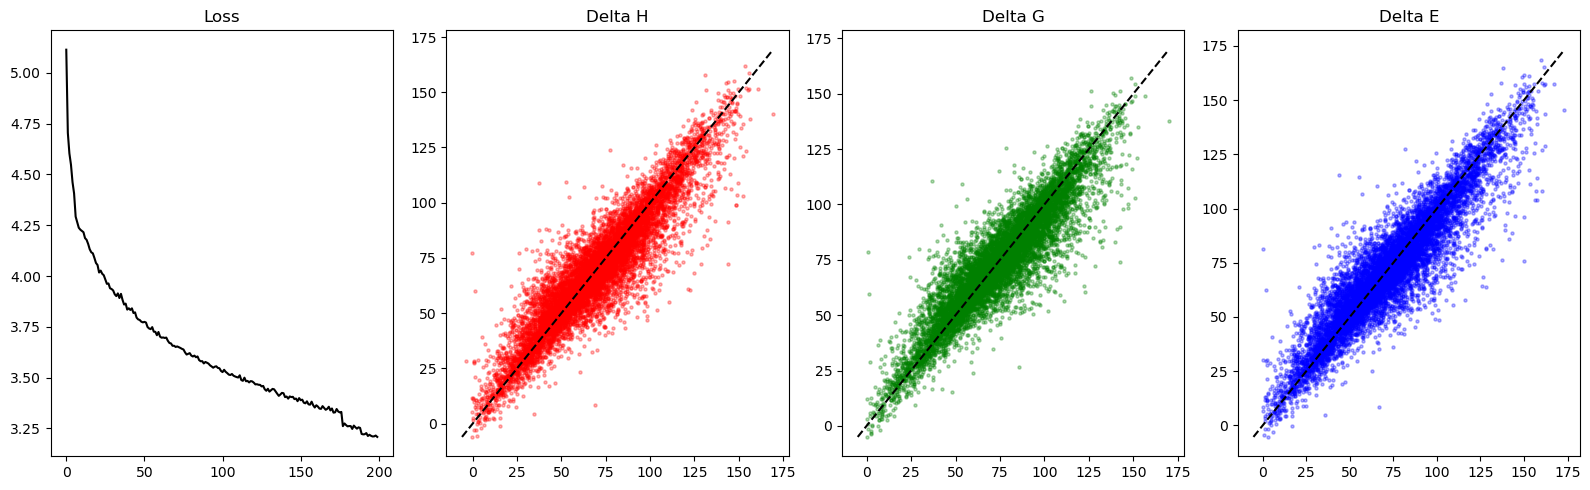

In [21]:
if __name__ == "__main__":
    import os
    base_dir = r"C:\Users\ansh1\OneDrive\OneDrive - personal\서류&파일\University of Seoul\연구\Code"
    MY_H5_PATH = os.path.join(base_dir, "RGD1_CHNO.h5")
    
    if os.path.exists(MY_H5_PATH):
        hist, r_E3, p_E3 = train(MY_H5_PATH, epochs=200, limit=10000)
        
        if hist:
            plt.figure(figsize=(16, 5))
            plt.subplot(1, 4, 1); plt.plot(hist['loss'], 'k-'); plt.title("Loss")
            titles, colors = ["Delta H", "Delta G", "Delta E"], ['r', 'g', 'b']
            keys = ['H', 'G', 'E']
            for i, k in enumerate(keys):
                plt.subplot(1, 4, i+2)
                plt.scatter(r_E3[k], p_E3[k], alpha=0.3, color=colors[i], s=5)
                mx = max(max(r_E3[k]), max(p_E3[k]))
                mn = min(min(r_E3[k]), min(p_E3[k]))
                plt.plot([mn, mx], [mn, mx], 'k--')
                plt.title(titles[i])
            plt.tight_layout()
            plt.show()
    else:
        print("파일을 찾을 수 없습니다.")

In [22]:
import numpy as np

def print_evaluation_report(real_dict, pred_dict):
    """
    학습 결과(정답 vs 예측)를 받아서 MAE, RMSE, R2, MSE를 계산하고 출력합니다.
    """
    print("\n" + "="*75)
    print(f"   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)")
    print("="*75)

    # 헤더 출력
    header = f"{'Energy Type':<15} | {'MAE':<10} | {'RMSE':<10} | {'MSE':<10} | {'R² Score':<10}"
    print(header)
    print("-" * 75)

    # H, G, E 각각에 대해 계산
    metrics = {}
    for key in ['H', 'G', 'E']:
        y_true = np.array(real_dict[key])
        y_pred = np.array(pred_dict[key])

        # 1. MAE (Mean Absolute Error)
        mae = np.mean(np.abs(y_true - y_pred))

        # 2. MSE (Mean Squared Error)
        mse = np.mean((y_true - y_pred)**2)

        # 3. RMSE (Root Mean Squared Error)
        rmse = np.sqrt(mse)

        # 4. R2 Score (Coefficient of Determination)
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        r2 = 1 - (ss_res / (ss_tot + 1e-8)) # 0으로 나누기 방지

        # 결과 저장
        metrics[key] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

        # 행 출력
        label = f"Delta {key} (Δ{key})"
        print(f"{label:<15} | {mae:<10.4f} | {rmse:<10.4f} | {mse:<10.4f} | {r2:<10.4f}")

    print("="*75)

    # [화학적 해석]
    # 화학적 정확도(Chemical Accuracy)는 보통 1 kcal/mol 이내를 말합니다.
    avg_mae = np.mean([metrics[k]['MAE'] for k in ['H', 'G', 'E']])
    print(f"⭐ Average MAE: {avg_mae:.4f} kcal/mol")

    if avg_mae < 2.5:
        print("✅ 모델이 물리 법칙(BEP, Hammond, Pauling)을 매우 잘 학습했습니다!")
        print("   (일반적인 DFT 계산 오차가 2~3 kcal/mol 수준임을 감안하면 훌륭합니다.)")
    elif avg_mae < 5.0:
        print("⚠️ 학습이 잘 되었으나, 일부 복잡한 반응에서 오차가 있습니다.")
    else:
        print("❌ 아직 과소적합 상태이거나 물리적 제약 조건이 더 필요합니다.")
    print("="*75 + "\n")

# ==============================================================================
# [실행 방법] main 블록 안에서 train()이 끝난 후 호출하세요
# ==============================================================================
if __name__ == "__main__":
    # 위에서 이미 train을 실행해서 r_E3, p_E3가 있다고 가정합니다.
    # 만약 변수가 메모리에 없다면 다시 학습을 돌려야 합니다.

    if 'r_E3' in locals() and 'p_E3' in locals():
        print_evaluation_report(r_E3, p_E3)
    else:
        print("먼저 train() 함수를 실행하여 r_E3, p_E3 변수를 생성해주세요.")


   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)
Energy Type     | MAE        | RMSE       | MSE        | R² Score  
---------------------------------------------------------------------------
Delta H (ΔH)    | 7.7296     | 10.8970    | 118.7446   | 0.8507    
Delta G (ΔG)    | 7.6911     | 10.8150    | 116.9633   | 0.8342    
Delta E (ΔE)    | 7.9807     | 11.2554    | 126.6851   | 0.8524    
⭐ Average MAE: 7.8005 kcal/mol
❌ 아직 과소적합 상태이거나 물리적 제약 조건이 더 필요합니다.

